In [1]:
%matplotlib inline

In [2]:
!pip3 install testfixtures --user

  Using cached https://files.pythonhosted.org/packages/39/ac/a2d5b0e8f25696b292b52fa4f54e36f51db83c5ad07aca4883501b198015/testfixtures-6.10.3-py2.py3-none-any.whl
You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.



A Reimplication of the 'Paragraph Vector' paper
==============================================================

Shows how to reproduce results of the "Distributed Representation of Sentences and Documents" paper by Le and Mikolov using Gensim.




In [3]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Introduction
------------

This guide shows you how to reproduce the results of the paper by `Le and
Mikolov 2014 <https://arxiv.org/pdf/1405.4053.pdf>`_ using Gensim. While the
entire paper is worth reading (it's only 9 pages), we will be focusing on
Section 3.2: "Beyond One Sentence - Sentiment Analysis with the IMDB
dataset".


Load corpus
-----------

Our data for the tutorial will be the `IMDB archive
<http://ai.stanford.edu/~amaas/data/sentiment/>`_.
If you're not familiar with this dataset, then here's a brief intro: it
contains several thousand movie reviews.

Each review is a single line of text containing multiple sentences, for example:

```
One of the best movie-dramas I have ever seen. We do a lot of acting in the
church and this is one that can be used as a resource that highlights all the
good things that actors can do in their work. I highly recommend this one,
especially for those who have an interest in acting, as a "must see."
```

These reviews will be the **documents** that we will work with in this tutorial.
There are 100 thousand reviews in total.

#. 25k reviews for training (12.5k positive, 12.5k negative)
#. 25k reviews for testing (12.5k positive, 12.5k negative)
#. 50k unlabeled reviews

Out of 100k reviews, 50k have a label: either positive (the reviewer liked
the movie) or negative.
The remaining 50k are unlabeled.

Our first task will be to prepare the dataset.



First, let's define a convenient datatype for holding data for a single document:

* words: The text of the document, as a ``list`` of words.
* tags: Used to keep the index of the document in the entire dataset.---document tags not sentiment labels
* split: one of ``train``\ , ``test`` or ``extra``. Determines how the document will be used (for training, testing, etc).
* sentiment: either 1 (positive), 0 (negative) or None (unlabeled document).

This data type is helpful for later evaluation and reporting.
In particular, the ``index`` member will help us quickly and easily retrieve the vectors for a document from a model.




In [4]:
import collections

SentimentDocument = collections.namedtuple('SentimentDocument', 'words tags split sentiment')

We can now proceed with loading the corpus.



In [5]:
import io
import re
import tarfile
import os.path

import smart_open
import gensim.utils

# def download_dataset(url='http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'):
#     fname = url.split('/')[-1]

#     if os.path.isfile(fname):
#        return fname

#     # Download the file to local storage first.
#     # We can't read it on the fly because of
#     # https://github.com/RaRe-Technologies/smart_open/issues/331
#     with smart_open.open(url, "rb", ignore_ext=True) as fin:
#         with smart_open.open(fname, 'wb', ignore_ext=True) as fout:
#             while True:
#                 buf = fin.read(io.DEFAULT_BUFFER_SIZE)
#                 if not buf:
#                     break
#                 fout.write(buf)

#     return fname
fname = 'aclImdb_v1.tar.gz'

def create_sentiment_document(name, text, index):
    _, split, sentiment_str, _ = name.split('/')
    sentiment = {'pos': 1.0, 'neg': 0.0, 'unsup': None}[sentiment_str]

    if sentiment is None:
        split = 'extra'

    tokens = gensim.utils.to_unicode(text).split()
    return SentimentDocument(tokens, [index], split, sentiment)

def extract_documents():
    index = 0
    
    with tarfile.open(fname, mode='r:gz') as tar:
        for member in tar.getmembers():
#             print(member.name)
            if re.match(r'aclImdb/(train|test)/(pos|neg|unsup)/\d+_\d+.txt$', member.name):
                member_bytes = tar.extractfile(member).read()
                member_text = member_bytes.decode('utf-8', errors='replace')
                assert member_text.count('\n') == 0
                yield create_sentiment_document(member.name, member_text, index)
                index += 1
                
alldocs = list(extract_documents())

In [6]:
'''
Get the p1's dataset, and use 10% round-robin cv list for test here. That's 200 reviews in total
'''
import glob
fname = 'p1'
def create_sentiment_document(name, text, index):
    _, split, sentiment_str, _ = name.split('/')
    sentiment = {'POS': 1.0, 'NEG': 0.0}[sentiment_str]
    tokens = text.split()
    return SentimentDocument(tokens, [index], split, sentiment)

def extract_documents():
    index = 0
    
    for files in glob.glob(fname +"/*/*/*.txt"):
        if re.match(r'p1/test/(POS|NEG)/.*_\d+.txt$', files):
            with open(files, 'r+',encoding='utf8') as f:
                temp = f.read().replace("\n","").replace('<br />', ' ')
                member_text= ''.join(temp)  
#                 print(member_text)
                assert member_text.count('\n') == 0
                yield create_sentiment_document(files, member_text, index)
                index += 1

p1docs = list(extract_documents())

In [8]:
p1docs[99].tags

[99]

Here's what a single document looks like



In [7]:
import numpy as np
# print(np.shape(alldocs))
print(alldocs[0])

SentimentDocument(words=['I', 'love', 'sci-fi', 'and', 'am', 'willing', 'to', 'put', 'up', 'with', 'a', 'lot.', 'Sci-fi', 'movies/TV', 'are', 'usually', 'underfunded,', 'under-appreciated', 'and', 'misunderstood.', 'I', 'tried', 'to', 'like', 'this,', 'I', 'really', 'did,', 'but', 'it', 'is', 'to', 'good', 'TV', 'sci-fi', 'as', 'Babylon', '5', 'is', 'to', 'Star', 'Trek', '(the', 'original).', 'Silly', 'prosthetics,', 'cheap', 'cardboard', 'sets,', 'stilted', 'dialogues,', 'CG', 'that', "doesn't", 'match', 'the', 'background,', 'and', 'painfully', 'one-dimensional', 'characters', 'cannot', 'be', 'overcome', 'with', 'a', "'sci-fi'", 'setting.', "(I'm", 'sure', 'there', 'are', 'those', 'of', 'you', 'out', 'there', 'who', 'think', 'Babylon', '5', 'is', 'good', 'sci-fi', 'TV.', "It's", 'not.', "It's", 'clichéd', 'and', 'uninspiring.)', 'While', 'US', 'viewers', 'might', 'like', 'emotion', 'and', 'character', 'development,', 'sci-fi', 'is', 'a', 'genre', 'that', 'does', 'not', 'take', 'itsel

Extract our documents and split into training/test sets



In [8]:
#the original training and testing dataset
train_docs = [doc for doc in alldocs if doc.split == 'train']
test_docs = [doc for doc in alldocs if doc.split == 'test']
print('%d docs: %d train-sentiment, %d test-sentiment' % (len(alldocs), len(train_docs), len(test_docs)))

100000 docs: 25000 train-sentiment, 25000 test-sentiment


here the tags can be used to do the round-robin splitting. Note:tags are "tag=\[n\]" shown in lists.

In [9]:
def cv_splits(target,splits=10):
    length = len(target)
    #if flatten
    temp = np.reshape(target,(splits,length//splits,4),order= "F").reshape((length,4))
    for item in temp:
        yield SentimentDocument._make(item)

#     return np.reshape(target,(splits,length//splits,4),order= "F")

In [10]:

'''
Note that the value of tags for train_docs starts from 25000;
Training on both train and test dataset for a blind test set: 50,000reviews
The blind test set uses p1's 10% dataset after cv(that is the first fold)
'''

'''
Only train on the assumed training dataset
'''
#process the training dataset
train_docs_p2 = test_docs+train_docs
cv_train_docs = list(cv_splits(train_docs_p2))

#process the testing dataset
_test_docs = list(cv_splits(p1docs))
cv_test_docs = _test_docs[:200]
# del cv_test_docs[200:] 


In [237]:
# cv_train_docs[37699].split

'train'

Set-up Doc2Vec Training & Evaluation Models
-------------------------------------------
We approximate the experiment of Le & Mikolov `"Distributed Representations
of Sentences and Documents"
<http://cs.stanford.edu/~quocle/paragraph_vector.pdf>`_ with guidance from
Mikolov's `example go.sh
<https://groups.google.com/d/msg/word2vec-toolkit/Q49FIrNOQRo/J6KG8mUj45sJ>`_::

    ./word2vec -train ../alldata-id.txt -output vectors.txt -cbow 0 -size 100 -window 10 -negative 5 -hs 0 -sample 1e-4 -threads 40 -binary 0 -iter 20 -min-count 1 -sentence-vectors 1

We vary the following parameter choices:

* 100-dimensional vectors, as the 400-d vectors of the paper take a lot of
  memory and, in our tests of this task, don't seem to offer much benefit
* Similarly, frequent word subsampling seems to decrease sentiment-prediction
  accuracy, so it's left out
* ``cbow=0`` means skip-gram which is equivalent to the paper's 'PV-DBOW'
  mode, matched in gensim with ``dm=0``
* Added to that DBOW model are two DM models, one which averages context
  vectors (\ ``dm_mean``\ ) and one which concatenates them (\ ``dm_concat``\ ,
  resulting in a much larger, slower, more data-hungry model)
* A ``min_count=2`` saves quite a bit of model memory, discarding only words
  that appear in a single doc (and are thus no more expressive than the
  unique-to-each doc vectors themselves)




In [14]:
#the first recording
import multiprocessing
from collections import OrderedDict

import gensim.models.doc2vec
assert gensim.models.doc2vec.FAST_VERSION > -1, "This will be painfully slow otherwise"

from gensim.models.doc2vec import Doc2Vec

common_kwargs = dict(
    vector_size=100, epochs=20, min_alpha = 1e-3, min_count=2,
    sample=0, workers=multiprocessing.cpu_count(), negative=5, hs=0,
)
common_kwargs_hs1 = dict(
    vector_size=100, epochs=20, min_alpha = 1e-3, min_count=2,
    sample=0, workers=multiprocessing.cpu_count(), negative=5, hs=1,
)

simple_models = [
    # PV-DBOW plain
    Doc2Vec(dm=0, **common_kwargs),
    # PV-DM w/ default averaging; a higher starting alpha may improve CBOW/PV-DM modes
    Doc2Vec(dm=1, window=10, alpha=0.05, comment='alpha=0.05', **common_kwargs),
    # PV-DM w/ concatenation - big, slow, experimental mode
    # window=5 (both sides) approximates paper's apparent 10-word total window size
    Doc2Vec(dm=1, dm_concat=1, window=5, **common_kwargs),
    # new added
    Doc2Vec(dm=1, window=2, alpha=0.05, comment='alpha=0.05', **common_kwargs),
    Doc2Vec(dm=1, window=10, alpha=0.025, comment='alpha=0.025', **common_kwargs),
    Doc2Vec(dm=1, window=5, comment='hs=0', **common_kwargs_hs1),
]

for model in simple_models:
#     path = str(model)+".model"
    model.build_vocab(alldocs)
#     model.save(path)
    print("%s vocabulary scanned & state initialized" % model)

models_by_name = OrderedDict((str(model), model) for model in simple_models)

2019-12-29 16:06:53,365 : INFO : using concatenative 1100-dimensional layer1
2019-12-29 16:06:53,367 : INFO : collecting all words and their counts
2019-12-29 16:06:53,367 : INFO : PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2019-12-29 16:06:53,737 : INFO : PROGRESS: at example #10000, processed 2292381 words (6206375/s), 150816 word types, 10000 tags
2019-12-29 16:06:54,122 : INFO : PROGRESS: at example #20000, processed 4573645 words (5938740/s), 238497 word types, 20000 tags
2019-12-29 16:06:54,529 : INFO : PROGRESS: at example #30000, processed 6865575 words (5639240/s), 312348 word types, 30000 tags
2019-12-29 16:06:54,946 : INFO : PROGRESS: at example #40000, processed 9190019 words (5596134/s), 377231 word types, 40000 tags
2019-12-29 16:06:55,349 : INFO : PROGRESS: at example #50000, processed 11557847 words (5877182/s), 438729 word types, 50000 tags
2019-12-29 16:06:55,741 : INFO : PROGRESS: at example #60000, processed 13899883 words (5988758/s), 49

Doc2Vec(dbow,d100,n5,mc2,t8) vocabulary scanned & state initialized


2019-12-29 16:07:53,778 : INFO : PROGRESS: at example #10000, processed 2292381 words (6611301/s), 150816 word types, 10000 tags
2019-12-29 16:07:54,160 : INFO : PROGRESS: at example #20000, processed 4573645 words (5987644/s), 238497 word types, 20000 tags
2019-12-29 16:07:54,534 : INFO : PROGRESS: at example #30000, processed 6865575 words (6140708/s), 312348 word types, 30000 tags
2019-12-29 16:07:54,922 : INFO : PROGRESS: at example #40000, processed 9190019 words (6001396/s), 377231 word types, 40000 tags
2019-12-29 16:07:55,303 : INFO : PROGRESS: at example #50000, processed 11557847 words (6218490/s), 438729 word types, 50000 tags
2019-12-29 16:07:55,688 : INFO : PROGRESS: at example #60000, processed 13899883 words (6099242/s), 493913 word types, 60000 tags
2019-12-29 16:07:56,083 : INFO : PROGRESS: at example #70000, processed 16270094 words (6002780/s), 548474 word types, 70000 tags
2019-12-29 16:07:56,470 : INFO : PROGRESS: at example #80000, processed 18598876 words (603544

Doc2Vec("alpha=0.05",dm/m,d100,n5,w10,mc2,t8) vocabulary scanned & state initialized


2019-12-29 16:08:54,919 : INFO : PROGRESS: at example #10000, processed 2292381 words (6584333/s), 150816 word types, 10000 tags
2019-12-29 16:08:55,300 : INFO : PROGRESS: at example #20000, processed 4573645 words (5998692/s), 238497 word types, 20000 tags
2019-12-29 16:08:55,714 : INFO : PROGRESS: at example #30000, processed 6865575 words (5547343/s), 312348 word types, 30000 tags
2019-12-29 16:08:56,144 : INFO : PROGRESS: at example #40000, processed 9190019 words (5407887/s), 377231 word types, 40000 tags
2019-12-29 16:08:56,682 : INFO : PROGRESS: at example #50000, processed 11557847 words (4409087/s), 438729 word types, 50000 tags
2019-12-29 16:08:57,125 : INFO : PROGRESS: at example #60000, processed 13899883 words (5295670/s), 493913 word types, 60000 tags
2019-12-29 16:08:57,525 : INFO : PROGRESS: at example #70000, processed 16270094 words (5940754/s), 548474 word types, 70000 tags
2019-12-29 16:08:57,907 : INFO : PROGRESS: at example #80000, processed 18598876 words (609366

Doc2Vec(dm/c,d100,n5,w5,mc2,t8) vocabulary scanned & state initialized


2019-12-29 16:09:54,751 : INFO : PROGRESS: at example #10000, processed 2292381 words (3351045/s), 150816 word types, 10000 tags
2019-12-29 16:09:55,127 : INFO : PROGRESS: at example #20000, processed 4573645 words (6080310/s), 238497 word types, 20000 tags
2019-12-29 16:09:55,510 : INFO : PROGRESS: at example #30000, processed 6865575 words (6003234/s), 312348 word types, 30000 tags
2019-12-29 16:09:56,040 : INFO : PROGRESS: at example #40000, processed 9190019 words (4390499/s), 377231 word types, 40000 tags
2019-12-29 16:09:56,446 : INFO : PROGRESS: at example #50000, processed 11557847 words (5848753/s), 438729 word types, 50000 tags
2019-12-29 16:09:56,843 : INFO : PROGRESS: at example #60000, processed 13899883 words (5905066/s), 493913 word types, 60000 tags
2019-12-29 16:09:57,248 : INFO : PROGRESS: at example #70000, processed 16270094 words (5853833/s), 548474 word types, 70000 tags
2019-12-29 16:09:57,635 : INFO : PROGRESS: at example #80000, processed 18598876 words (604108

Doc2Vec("alpha=0.05",dm/m,d100,n5,w2,mc2,t8) vocabulary scanned & state initialized


2019-12-29 16:10:51,923 : INFO : PROGRESS: at example #10000, processed 2292381 words (6825395/s), 150816 word types, 10000 tags
2019-12-29 16:10:52,279 : INFO : PROGRESS: at example #20000, processed 4573645 words (6416892/s), 238497 word types, 20000 tags
2019-12-29 16:10:52,646 : INFO : PROGRESS: at example #30000, processed 6865575 words (6255750/s), 312348 word types, 30000 tags
2019-12-29 16:10:53,033 : INFO : PROGRESS: at example #40000, processed 9190019 words (6016329/s), 377231 word types, 40000 tags
2019-12-29 16:10:53,420 : INFO : PROGRESS: at example #50000, processed 11557847 words (6129708/s), 438729 word types, 50000 tags
2019-12-29 16:10:53,802 : INFO : PROGRESS: at example #60000, processed 13899883 words (6145852/s), 493913 word types, 60000 tags
2019-12-29 16:10:54,193 : INFO : PROGRESS: at example #70000, processed 16270094 words (6066147/s), 548474 word types, 70000 tags
2019-12-29 16:10:54,593 : INFO : PROGRESS: at example #80000, processed 18598876 words (582719

Doc2Vec("alpha=0.025",dm/m,d100,n5,w10,mc2,t8) vocabulary scanned & state initialized


2019-12-29 16:11:48,815 : INFO : PROGRESS: at example #10000, processed 2292381 words (6716571/s), 150816 word types, 10000 tags
2019-12-29 16:11:49,166 : INFO : PROGRESS: at example #20000, processed 4573645 words (6513553/s), 238497 word types, 20000 tags
2019-12-29 16:11:49,532 : INFO : PROGRESS: at example #30000, processed 6865575 words (6270864/s), 312348 word types, 30000 tags
2019-12-29 16:11:49,921 : INFO : PROGRESS: at example #40000, processed 9190019 words (5985161/s), 377231 word types, 40000 tags
2019-12-29 16:11:50,312 : INFO : PROGRESS: at example #50000, processed 11557847 words (6065485/s), 438729 word types, 50000 tags
2019-12-29 16:11:50,694 : INFO : PROGRESS: at example #60000, processed 13899883 words (6140063/s), 493913 word types, 60000 tags
2019-12-29 16:11:51,093 : INFO : PROGRESS: at example #70000, processed 16270094 words (5951262/s), 548474 word types, 70000 tags
2019-12-29 16:11:51,478 : INFO : PROGRESS: at example #80000, processed 18598876 words (605616

Doc2Vec("hs=0",dm/m,d100,n5,hs,w5,mc2,t8) vocabulary scanned & state initialized


In [56]:
#the second recording
import multiprocessing
from collections import OrderedDict

import gensim.models.doc2vec
assert gensim.models.doc2vec.FAST_VERSION > -1, "This will be painfully slow otherwise"

from gensim.models.doc2vec import Doc2Vec

common_kwargs = dict(
    vector_size=100, epochs=10, min_alpha = 1e-3, min_count=2,
    sample=0, workers=multiprocessing.cpu_count(), negative=5, hs=0,
)
common_kwargs_mc5 = dict(
    vector_size=100, epochs=10, min_alpha = 1e-3, min_count=5,
    sample=0, workers=multiprocessing.cpu_count(), negative=5, hs=0,
)

simple_models = [
    # PV-DBOW plain
    Doc2Vec(dm=0, **common_kwargs),
    # PV-DM w/ default averaging; a higher starting alpha may improve CBOW/PV-DM modes
    Doc2Vec(dm=1, window=2, alpha=0.05, comment='w2', **common_kwargs),
    # PV-DM w/ concatenation - big, slow, experimental mode
    # window=5 (both sides) approximates paper's apparent 10-word total window size
#     Doc2Vec(dm=1, dm_concat=1, window=5, **common_kwargs),
    # new added
    Doc2Vec(dm=1, window=5, alpha=0.05, comment='mc5w5', **common_kwargs_mc5),
    Doc2Vec(dm=1, window=2, alpha=0.05, comment='mc5w2', **common_kwargs),
]

for model in simple_models:
#     path = str(model)+".model"
    model.build_vocab(alldocs)
#     model.save(path)
    print("%s vocabulary scanned & state initialized" % model)

models_by_name = OrderedDict((str(model), model) for model in simple_models)

2019-12-29 21:22:31,081 : INFO : collecting all words and their counts
2019-12-29 21:22:31,082 : INFO : PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2019-12-29 21:22:31,469 : INFO : PROGRESS: at example #10000, processed 2292381 words (5955446/s), 150816 word types, 10000 tags
2019-12-29 21:22:31,925 : INFO : PROGRESS: at example #20000, processed 4573645 words (5009225/s), 238497 word types, 20000 tags
2019-12-29 21:22:32,431 : INFO : PROGRESS: at example #30000, processed 6865575 words (4536743/s), 312348 word types, 30000 tags
2019-12-29 21:22:32,970 : INFO : PROGRESS: at example #40000, processed 9190019 words (4321001/s), 377231 word types, 40000 tags
2019-12-29 21:22:33,531 : INFO : PROGRESS: at example #50000, processed 11557847 words (4217995/s), 438729 word types, 50000 tags
2019-12-29 21:22:34,123 : INFO : PROGRESS: at example #60000, processed 13899883 words (3965459/s), 493913 word types, 60000 tags
2019-12-29 21:22:34,721 : INFO : PROGRESS: at exa

Doc2Vec(dbow,d100,n5,mc2,t8) vocabulary scanned & state initialized


2019-12-29 21:23:31,409 : INFO : PROGRESS: at example #10000, processed 2292381 words (6529284/s), 150816 word types, 10000 tags
2019-12-29 21:23:31,762 : INFO : PROGRESS: at example #20000, processed 4573645 words (6473825/s), 238497 word types, 20000 tags
2019-12-29 21:23:32,120 : INFO : PROGRESS: at example #30000, processed 6865575 words (6419631/s), 312348 word types, 30000 tags
2019-12-29 21:23:32,511 : INFO : PROGRESS: at example #40000, processed 9190019 words (5955064/s), 377231 word types, 40000 tags
2019-12-29 21:23:32,897 : INFO : PROGRESS: at example #50000, processed 11557847 words (6136023/s), 438729 word types, 50000 tags
2019-12-29 21:23:33,281 : INFO : PROGRESS: at example #60000, processed 13899883 words (6113918/s), 493913 word types, 60000 tags
2019-12-29 21:23:33,677 : INFO : PROGRESS: at example #70000, processed 16270094 words (5997696/s), 548474 word types, 70000 tags
2019-12-29 21:23:34,058 : INFO : PROGRESS: at example #80000, processed 18598876 words (611573

Doc2Vec("w2",dm/m,d100,n5,w2,mc2,t8) vocabulary scanned & state initialized


2019-12-29 21:24:30,194 : INFO : PROGRESS: at example #10000, processed 2292381 words (6514034/s), 150816 word types, 10000 tags
2019-12-29 21:24:30,550 : INFO : PROGRESS: at example #20000, processed 4573645 words (6419475/s), 238497 word types, 20000 tags
2019-12-29 21:24:30,911 : INFO : PROGRESS: at example #30000, processed 6865575 words (6357057/s), 312348 word types, 30000 tags
2019-12-29 21:24:31,294 : INFO : PROGRESS: at example #40000, processed 9190019 words (6080518/s), 377231 word types, 40000 tags
2019-12-29 21:24:31,681 : INFO : PROGRESS: at example #50000, processed 11557847 words (6120498/s), 438729 word types, 50000 tags
2019-12-29 21:24:32,071 : INFO : PROGRESS: at example #60000, processed 13899883 words (6026253/s), 493913 word types, 60000 tags
2019-12-29 21:24:32,467 : INFO : PROGRESS: at example #70000, processed 16270094 words (5998100/s), 548474 word types, 70000 tags
2019-12-29 21:24:32,858 : INFO : PROGRESS: at example #80000, processed 18598876 words (595620

Doc2Vec("mc5w5",dm/m,d100,n5,w5,mc5,t8) vocabulary scanned & state initialized


2019-12-29 21:25:06,655 : INFO : PROGRESS: at example #10000, processed 2292381 words (6695475/s), 150816 word types, 10000 tags
2019-12-29 21:25:07,007 : INFO : PROGRESS: at example #20000, processed 4573645 words (6484377/s), 238497 word types, 20000 tags
2019-12-29 21:25:07,371 : INFO : PROGRESS: at example #30000, processed 6865575 words (6307714/s), 312348 word types, 30000 tags
2019-12-29 21:25:07,756 : INFO : PROGRESS: at example #40000, processed 9190019 words (6049073/s), 377231 word types, 40000 tags
2019-12-29 21:25:08,138 : INFO : PROGRESS: at example #50000, processed 11557847 words (6215443/s), 438729 word types, 50000 tags
2019-12-29 21:25:08,517 : INFO : PROGRESS: at example #60000, processed 13899883 words (6182495/s), 493913 word types, 60000 tags
2019-12-29 21:25:08,907 : INFO : PROGRESS: at example #70000, processed 16270094 words (6092665/s), 548474 word types, 70000 tags
2019-12-29 21:25:09,295 : INFO : PROGRESS: at example #80000, processed 18598876 words (600742

Doc2Vec("mc5w2",dm/m,d100,n5,w2,mc2,t8) vocabulary scanned & state initialized


In [11]:
#the third round:optimisation round
import multiprocessing
from collections import OrderedDict

import gensim.models.doc2vec
assert gensim.models.doc2vec.FAST_VERSION > -1, "This will be painfully slow otherwise"

from gensim.models.doc2vec import Doc2Vec

common_kwargs = dict(
    vector_size=100, epochs=20, min_alpha = 1e-3, min_count=2,
    sample=0, workers=multiprocessing.cpu_count(), negative=5, hs=0,
)

simple_models = [
    # PV-DBOW plain
    Doc2Vec(dm=0, **common_kwargs),
    # PV-DM w/ default averaging; a higher starting alpha may improve CBOW/PV-DM modes
    Doc2Vec(dm=1, dm_mean=1, window=2, alpha=0.05, comment='mean', **common_kwargs),
    # PV-DM w/ concatenation - big, slow, experimental mode
    # window=5 (both sides) approximates paper's apparent 10-word total window size
    Doc2Vec(dm=1, dm_mean=0, window=2, alpha=0.05, comment='sum', **common_kwargs),
]

for model in simple_models:
#     path = str(model)+".model"
    model.build_vocab(alldocs)
#     model.save(path)
    print("%s vocabulary scanned & state initialized" % model)

models_by_name = OrderedDict((str(model), model) for model in simple_models)

2020-01-08 21:05:12,671 : INFO : collecting all words and their counts
2020-01-08 21:05:12,672 : INFO : PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2020-01-08 21:05:13,030 : INFO : PROGRESS: at example #10000, processed 2292381 words (6412931/s), 150816 word types, 10000 tags
2020-01-08 21:05:13,428 : INFO : PROGRESS: at example #20000, processed 4573645 words (5749204/s), 238497 word types, 20000 tags
2020-01-08 21:05:13,824 : INFO : PROGRESS: at example #30000, processed 6865575 words (5797971/s), 312348 word types, 30000 tags
2020-01-08 21:05:14,245 : INFO : PROGRESS: at example #40000, processed 9190019 words (5526029/s), 377231 word types, 40000 tags
2020-01-08 21:05:14,656 : INFO : PROGRESS: at example #50000, processed 11557847 words (5764988/s), 438729 word types, 50000 tags
2020-01-08 21:05:15,063 : INFO : PROGRESS: at example #60000, processed 13899883 words (5766633/s), 493913 word types, 60000 tags
2020-01-08 21:05:15,468 : INFO : PROGRESS: at exa

Doc2Vec(dbow,d100,n5,mc2,t8) vocabulary scanned & state initialized


2020-01-08 21:06:15,248 : INFO : PROGRESS: at example #10000, processed 2292381 words (7231367/s), 150816 word types, 10000 tags
2020-01-08 21:06:15,572 : INFO : PROGRESS: at example #20000, processed 4573645 words (7056478/s), 238497 word types, 20000 tags
2020-01-08 21:06:15,933 : INFO : PROGRESS: at example #30000, processed 6865575 words (6366644/s), 312348 word types, 30000 tags
2020-01-08 21:06:16,323 : INFO : PROGRESS: at example #40000, processed 9190019 words (5967488/s), 377231 word types, 40000 tags
2020-01-08 21:06:16,719 : INFO : PROGRESS: at example #50000, processed 11557847 words (5986612/s), 438729 word types, 50000 tags
2020-01-08 21:06:17,107 : INFO : PROGRESS: at example #60000, processed 13899883 words (6047371/s), 493913 word types, 60000 tags
2020-01-08 21:06:17,497 : INFO : PROGRESS: at example #70000, processed 16270094 words (6078932/s), 548474 word types, 70000 tags
2020-01-08 21:06:17,868 : INFO : PROGRESS: at example #80000, processed 18598876 words (629077

Doc2Vec("mean",dm/m,d100,n5,w2,mc2,t8) vocabulary scanned & state initialized


2020-01-08 21:07:15,317 : INFO : PROGRESS: at example #10000, processed 2292381 words (6969724/s), 150816 word types, 10000 tags
2020-01-08 21:07:15,653 : INFO : PROGRESS: at example #20000, processed 4573645 words (6805052/s), 238497 word types, 20000 tags
2020-01-08 21:07:16,012 : INFO : PROGRESS: at example #30000, processed 6865575 words (6391741/s), 312348 word types, 30000 tags
2020-01-08 21:07:16,386 : INFO : PROGRESS: at example #40000, processed 9190019 words (6231791/s), 377231 word types, 40000 tags
2020-01-08 21:07:16,763 : INFO : PROGRESS: at example #50000, processed 11557847 words (6283542/s), 438729 word types, 50000 tags
2020-01-08 21:07:17,135 : INFO : PROGRESS: at example #60000, processed 13899883 words (6309707/s), 493913 word types, 60000 tags
2020-01-08 21:07:17,505 : INFO : PROGRESS: at example #70000, processed 16270094 words (6418973/s), 548474 word types, 70000 tags
2020-01-08 21:07:17,870 : INFO : PROGRESS: at example #80000, processed 18598876 words (639757

Doc2Vec("sum",dm/s,d100,n5,w2,mc2,t8) vocabulary scanned & state initialized


Le and Mikolov note that combining a paragraph vector from Distributed Bag of
Words (DBOW) and Distributed Memory (DM) improves performance. We will
follow, pairing the models together for evaluation. Here, we concatenate the
paragraph vectors obtained from each model with the help of a thin wrapper
class included in a gensim test module. (Note that this a separate, later
concatenation of output-vectors than the kind of input-window-concatenation
enabled by the ``dm_concat=1`` mode above.)




In [12]:
from gensim.test.test_doc2vec import ConcatenatedDoc2Vec
models_by_name['dbow+dmm'] = ConcatenatedDoc2Vec([simple_models[0], simple_models[1]])
models_by_name['dbow+dmc'] = ConcatenatedDoc2Vec([simple_models[0], simple_models[2]])

2020-01-08 21:08:17,412 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-01-08 21:08:17,413 : INFO : built Dictionary(12 unique tokens: ['computer', 'human', 'interface', 'response', 'survey']...) from 9 documents (total 29 corpus positions)


In [16]:
type(models_by_name)

collections.OrderedDict

In [18]:
simple_models

Predictive Evaluation Methods
-----------------------------

Given a document, our ``Doc2Vec`` models output a vector representation of the document.
How useful is a particular model?
In case of sentiment analysis, we want the ouput vector to reflect the sentiment in the input document.
So, in vector space, positive documents should be distant from negative documents.

We train a logistic regression from the training set:

  - regressors (inputs): document vectors from the Doc2Vec model
  - target (outpus): sentiment labels

So, this logistic regression will be able to predict sentiment given a document vector.

Next, we test our logistic regression on the test set, and measure the rate of errors (incorrect predictions).
If the document vectors from the Doc2Vec model reflect the actual sentiment well, the error rate will be low.

Therefore, the error rate of the logistic regression is indication of *how well* the given Doc2Vec model represents documents as vectors.
We can then compare different ``Doc2Vec`` models by looking at their error rates.




In [13]:
import numpy as np
import statsmodels.api as sm
from random import sample

from sklearn import svm
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold

# def logistic_predictor_from_data(train_targets, train_regressors):
#     """Fit a statsmodel logistic predictor on supplied data"""
#     logit = sm.Logit(train_targets, train_regressors)
#     predictor = logit.fit(disp=0)
#     # print(predictor.summary())
#     return predictor

# def SVM_pred_from_data(train_targets, train_features):
#     svm_clf = SGDClassifier(alpha=1e-3,warm_start=True)
#     predictor = svm_clf.fit(train_features,train_targets)
#     return predictor

def SVM_pred_from_data_cv(train_targets, train_features):
#     svm_clf = SGDClassifier(alpha=1e-3,warm_start=True,early_stopping=True,validation_fraction=0.1)
    svm_clf = SGDClassifier(alpha=1e-3)
#     svm_clf = svm.SVC(kernel='linear')
#     svm_clf = svm.SVC(kernel='poly')
#     svm_clf = svm.SVC(kernel='rbf')
#     svm_clf = svm.SVC(kernel='sigmoid')
    predictor = svm_clf.fit(train_features,train_targets)
        
    return predictor


def result_rates_for_model(test_model, train_set, test_docvecs, test_targets):
    """Report error rate and correct rate on test_doc sentiments, using supplied model and train_docs"""

    train_targets = [doc.sentiment for doc in train_set]
    train_features = [test_model.docvecs[doc.tags[0]] for doc in train_set]
#     this is not lofic regression so don't need to add "b"(in y=ax+b)
#     train_regressors = sm.add_constant(train_regressors) 
#     predictor = logistic_predictor_from_data(train_targets, train_regressors)
#     predictor = SVM_pred_from_data(train_targets,train_features)
    predictor = SVM_pred_from_data_cv(train_targets,train_features)

    '''Note:change the volume of testdata and the name'''

    # Predict & evaluate
    test_predictions = predictor.predict(test_docvecs)
    num_test = len(test_predictions)
    corrects = sum(np.rint(test_predictions) == test_targets)
    errors =  num_test - corrects
    error_rate = float(errors) / num_test
    correct_rate = float(corrects) / num_test
    return (error_rate, errors, correct_rate, corrects, num_test, predictor, test_predictions, test_targets)

Bulk Training & Per-Model Evaluation
------------------------------------

Note that doc-vector training is occurring on *all* documents of the dataset,
which includes all TRAIN/TEST/DEV docs.  Because the native document-order
has similar-sentiment documents in large clumps – which is suboptimal for
training – we work with once-shuffled copy of the training set.

We evaluate each model's sentiment predictive power based on error rate, and
the evaluation is done for each model.

(On a 4-core 2.6Ghz Intel Core i7, these 20 passes training and evaluating 3
main models takes about an hour.)




In [14]:
from collections import defaultdict
error_rates = defaultdict(lambda: 1.0)  # To selectively print only best errors achieved

### training doc2vec model on 10,000 reviews

In [15]:
from datetime import datetime
from random import shuffle
shuffled_alldocs = alldocs[:]
shuffle(shuffled_alldocs)

for model in simple_models:
    start=datetime.now()
    print("Training %s\n" % model)
    model.train(shuffled_alldocs, total_examples=len(shuffled_alldocs), epochs=model.epochs)
    print(datetime.now()-start)

2020-01-08 21:08:18,900 : INFO : training model with 8 workers on 265408 vocabulary and 100 features, using sg=1 hs=0 sample=0 negative=5 window=5


Training Doc2Vec(dbow,d100,n5,mc2,t8)



2020-01-08 21:08:19,929 : INFO : EPOCH 1 - PROGRESS: at 5.99% examples, 1339433 words/s, in_qsize 15, out_qsize 0
2020-01-08 21:08:20,933 : INFO : EPOCH 1 - PROGRESS: at 12.82% examples, 1449859 words/s, in_qsize 15, out_qsize 0
2020-01-08 21:08:21,936 : INFO : EPOCH 1 - PROGRESS: at 19.31% examples, 1458794 words/s, in_qsize 14, out_qsize 1
2020-01-08 21:08:22,950 : INFO : EPOCH 1 - PROGRESS: at 25.84% examples, 1466238 words/s, in_qsize 15, out_qsize 0
2020-01-08 21:08:23,954 : INFO : EPOCH 1 - PROGRESS: at 32.32% examples, 1462787 words/s, in_qsize 15, out_qsize 0
2020-01-08 21:08:24,954 : INFO : EPOCH 1 - PROGRESS: at 38.75% examples, 1463026 words/s, in_qsize 15, out_qsize 0
2020-01-08 21:08:25,961 : INFO : EPOCH 1 - PROGRESS: at 45.33% examples, 1471180 words/s, in_qsize 14, out_qsize 1
2020-01-08 21:08:26,965 : INFO : EPOCH 1 - PROGRESS: at 52.05% examples, 1482183 words/s, in_qsize 14, out_qsize 1
2020-01-08 21:08:27,970 : INFO : EPOCH 1 - PROGRESS: at 58.88% examples, 1494034 

2020-01-08 21:09:10,825 : INFO : EPOCH 4 - PROGRESS: at 76.35% examples, 1743013 words/s, in_qsize 15, out_qsize 0
2020-01-08 21:09:11,829 : INFO : EPOCH 4 - PROGRESS: at 84.01% examples, 1744632 words/s, in_qsize 15, out_qsize 0
2020-01-08 21:09:12,848 : INFO : EPOCH 4 - PROGRESS: at 91.66% examples, 1742813 words/s, in_qsize 15, out_qsize 0
2020-01-08 21:09:13,868 : INFO : EPOCH 4 - PROGRESS: at 99.32% examples, 1741043 words/s, in_qsize 15, out_qsize 1
2020-01-08 21:09:13,916 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-01-08 21:09:13,923 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-01-08 21:09:13,925 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-01-08 21:09:13,926 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-01-08 21:09:13,928 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-08 21:09:13,932 : INFO : worker thread finished; awaiting finish of 2 more th

2020-01-08 21:09:54,370 : INFO : EPOCH 8 - PROGRESS: at 7.36% examples, 1667977 words/s, in_qsize 15, out_qsize 0
2020-01-08 21:09:55,376 : INFO : EPOCH 8 - PROGRESS: at 15.14% examples, 1719937 words/s, in_qsize 15, out_qsize 0
2020-01-08 21:09:56,392 : INFO : EPOCH 8 - PROGRESS: at 22.87% examples, 1733541 words/s, in_qsize 15, out_qsize 0
2020-01-08 21:09:57,402 : INFO : EPOCH 8 - PROGRESS: at 30.71% examples, 1736534 words/s, in_qsize 14, out_qsize 1
2020-01-08 21:09:58,403 : INFO : EPOCH 8 - PROGRESS: at 38.41% examples, 1738469 words/s, in_qsize 15, out_qsize 0
2020-01-08 21:09:59,406 : INFO : EPOCH 8 - PROGRESS: at 46.08% examples, 1745803 words/s, in_qsize 15, out_qsize 0
2020-01-08 21:10:00,418 : INFO : EPOCH 8 - PROGRESS: at 53.69% examples, 1747732 words/s, in_qsize 15, out_qsize 0
2020-01-08 21:10:01,430 : INFO : EPOCH 8 - PROGRESS: at 61.26% examples, 1746907 words/s, in_qsize 15, out_qsize 0
2020-01-08 21:10:02,436 : INFO : EPOCH 8 - PROGRESS: at 68.90% examples, 1746619 

2020-01-08 21:10:43,802 : INFO : EPOCH 11 - PROGRESS: at 84.13% examples, 1746568 words/s, in_qsize 15, out_qsize 0
2020-01-08 21:10:44,808 : INFO : EPOCH 11 - PROGRESS: at 91.74% examples, 1745636 words/s, in_qsize 14, out_qsize 1
2020-01-08 21:10:45,811 : INFO : EPOCH 11 - PROGRESS: at 99.52% examples, 1748039 words/s, in_qsize 11, out_qsize 0
2020-01-08 21:10:45,829 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-01-08 21:10:45,838 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-01-08 21:10:45,846 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-01-08 21:10:45,849 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-01-08 21:10:45,852 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-08 21:10:45,857 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-08 21:10:45,858 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-08 21:1

2020-01-08 21:11:25,435 : INFO : EPOCH - 14 : training on 23279529 raw words (22951015 effective words) took 13.2s, 1733003 effective words/s
2020-01-08 21:11:26,440 : INFO : EPOCH 15 - PROGRESS: at 7.52% examples, 1709731 words/s, in_qsize 16, out_qsize 0
2020-01-08 21:11:27,441 : INFO : EPOCH 15 - PROGRESS: at 15.10% examples, 1721685 words/s, in_qsize 15, out_qsize 0
2020-01-08 21:11:28,443 : INFO : EPOCH 15 - PROGRESS: at 22.54% examples, 1720020 words/s, in_qsize 15, out_qsize 0
2020-01-08 21:11:29,455 : INFO : EPOCH 15 - PROGRESS: at 30.31% examples, 1723212 words/s, in_qsize 15, out_qsize 0
2020-01-08 21:11:30,467 : INFO : EPOCH 15 - PROGRESS: at 38.04% examples, 1724079 words/s, in_qsize 14, out_qsize 1
2020-01-08 21:11:31,473 : INFO : EPOCH 15 - PROGRESS: at 45.74% examples, 1734827 words/s, in_qsize 15, out_qsize 0
2020-01-08 21:11:32,474 : INFO : EPOCH 15 - PROGRESS: at 53.41% examples, 1742192 words/s, in_qsize 15, out_qsize 0
2020-01-08 21:11:33,477 : INFO : EPOCH 15 - PRO

2020-01-08 21:12:13,869 : INFO : EPOCH 18 - PROGRESS: at 68.86% examples, 1751333 words/s, in_qsize 15, out_qsize 0
2020-01-08 21:12:14,875 : INFO : EPOCH 18 - PROGRESS: at 76.42% examples, 1745753 words/s, in_qsize 14, out_qsize 1
2020-01-08 21:12:15,884 : INFO : EPOCH 18 - PROGRESS: at 84.00% examples, 1744752 words/s, in_qsize 14, out_qsize 1
2020-01-08 21:12:16,884 : INFO : EPOCH 18 - PROGRESS: at 91.70% examples, 1746416 words/s, in_qsize 15, out_qsize 0
2020-01-08 21:12:17,891 : INFO : EPOCH 18 - PROGRESS: at 99.45% examples, 1747477 words/s, in_qsize 13, out_qsize 0
2020-01-08 21:12:17,921 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-01-08 21:12:17,926 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-01-08 21:12:17,937 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-01-08 21:12:17,940 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-01-08 21:12:17,945 : INFO : worker thread finished;

0:04:25.278376
Training Doc2Vec("mean",dm/m,d100,n5,w2,mc2,t8)



2020-01-08 21:12:45,188 : INFO : EPOCH 1 - PROGRESS: at 5.30% examples, 1208067 words/s, in_qsize 15, out_qsize 0
2020-01-08 21:12:46,192 : INFO : EPOCH 1 - PROGRESS: at 11.05% examples, 1260218 words/s, in_qsize 16, out_qsize 0
2020-01-08 21:12:47,195 : INFO : EPOCH 1 - PROGRESS: at 16.64% examples, 1260763 words/s, in_qsize 15, out_qsize 0
2020-01-08 21:12:48,203 : INFO : EPOCH 1 - PROGRESS: at 22.15% examples, 1264619 words/s, in_qsize 15, out_qsize 0
2020-01-08 21:12:49,207 : INFO : EPOCH 1 - PROGRESS: at 27.85% examples, 1270136 words/s, in_qsize 15, out_qsize 0
2020-01-08 21:12:50,209 : INFO : EPOCH 1 - PROGRESS: at 33.58% examples, 1271468 words/s, in_qsize 15, out_qsize 0
2020-01-08 21:12:51,213 : INFO : EPOCH 1 - PROGRESS: at 39.36% examples, 1278899 words/s, in_qsize 15, out_qsize 0
2020-01-08 21:12:52,222 : INFO : EPOCH 1 - PROGRESS: at 45.05% examples, 1282185 words/s, in_qsize 15, out_qsize 0
2020-01-08 21:12:53,232 : INFO : EPOCH 1 - PROGRESS: at 50.78% examples, 1286661 

2020-01-08 21:13:37,263 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-08 21:13:37,264 : INFO : EPOCH - 3 : training on 23279529 raw words (22951015 effective words) took 17.5s, 1310964 effective words/s
2020-01-08 21:13:38,293 : INFO : EPOCH 4 - PROGRESS: at 5.65% examples, 1255604 words/s, in_qsize 15, out_qsize 0
2020-01-08 21:13:39,297 : INFO : EPOCH 4 - PROGRESS: at 11.45% examples, 1293342 words/s, in_qsize 15, out_qsize 0
2020-01-08 21:13:40,309 : INFO : EPOCH 4 - PROGRESS: at 17.29% examples, 1297912 words/s, in_qsize 15, out_qsize 0
2020-01-08 21:13:41,310 : INFO : EPOCH 4 - PROGRESS: at 23.00% examples, 1304797 words/s, in_qsize 15, out_qsize 0
2020-01-08 21:13:42,316 : INFO : EPOCH 4 - PROGRESS: at 28.73% examples, 1301936 words/s, in_qsize 15, out_qsize 0
2020-01-08 21:13:43,330 : INFO : EPOCH 4 - PROGRESS: at 34.50% examples, 1298700 words/s, in_qsize 15, out_qsize 0
2020-01-08 21:13:44,337 : INFO : EPOCH 4 - PROGRESS: at 40.16% examples, 129716

2020-01-08 21:14:29,918 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-08 21:14:29,923 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-08 21:14:29,927 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-08 21:14:29,935 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-08 21:14:29,936 : INFO : EPOCH - 6 : training on 23279529 raw words (22951015 effective words) took 17.5s, 1308627 effective words/s
2020-01-08 21:14:30,966 : INFO : EPOCH 7 - PROGRESS: at 5.65% examples, 1253238 words/s, in_qsize 15, out_qsize 0
2020-01-08 21:14:31,968 : INFO : EPOCH 7 - PROGRESS: at 11.50% examples, 1298563 words/s, in_qsize 16, out_qsize 0
2020-01-08 21:14:32,969 : INFO : EPOCH 7 - PROGRESS: at 17.29% examples, 1302776 words/s, in_qsize 15, out_qsize 0
2020-01-08 21:14:33,975 : INFO : EPOCH 7 - PROGRESS: at 22.86% examples, 1299634 words/s, in_qsize 15, out_qsize 0
2020-01-08 21:14:34,982 : INFO : EPO

2020-01-08 21:15:22,516 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-01-08 21:15:22,525 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-01-08 21:15:22,529 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-01-08 21:15:22,532 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-08 21:15:22,536 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-08 21:15:22,539 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-08 21:15:22,545 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-08 21:15:22,546 : INFO : EPOCH - 9 : training on 23279529 raw words (22951015 effective words) took 17.5s, 1310071 effective words/s
2020-01-08 21:15:23,566 : INFO : EPOCH 10 - PROGRESS: at 5.65% examples, 1265890 words/s, in_qsize 15, out_qsize 0
2020-01-08 21:15:24,568 : INFO : EPOCH 10 - PROGRESS: at 11.41% examples, 1295050 words/s, in_qsize 15, out

2020-01-08 21:16:13,593 : INFO : EPOCH 12 - PROGRESS: at 88.76% examples, 1264935 words/s, in_qsize 15, out_qsize 0
2020-01-08 21:16:14,601 : INFO : EPOCH 12 - PROGRESS: at 94.16% examples, 1263418 words/s, in_qsize 15, out_qsize 0
2020-01-08 21:16:15,575 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-01-08 21:16:15,584 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-01-08 21:16:15,587 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-01-08 21:16:15,593 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-01-08 21:16:15,597 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-08 21:16:15,600 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-08 21:16:15,602 : INFO : EPOCH 12 - PROGRESS: at 99.96% examples, 1266402 words/s, in_qsize 1, out_qsize 1
2020-01-08 21:16:15,603 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-08 21:16

2020-01-08 21:17:03,803 : INFO : EPOCH 15 - PROGRESS: at 75.20% examples, 1317151 words/s, in_qsize 15, out_qsize 0
2020-01-08 21:17:04,809 : INFO : EPOCH 15 - PROGRESS: at 81.00% examples, 1316580 words/s, in_qsize 15, out_qsize 0
2020-01-08 21:17:05,809 : INFO : EPOCH 15 - PROGRESS: at 86.65% examples, 1316480 words/s, in_qsize 15, out_qsize 0
2020-01-08 21:17:06,819 : INFO : EPOCH 15 - PROGRESS: at 92.57% examples, 1318209 words/s, in_qsize 15, out_qsize 0
2020-01-08 21:17:07,821 : INFO : EPOCH 15 - PROGRESS: at 98.32% examples, 1317477 words/s, in_qsize 15, out_qsize 0
2020-01-08 21:17:08,060 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-01-08 21:17:08,067 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-01-08 21:17:08,070 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-01-08 21:17:08,075 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-01-08 21:17:08,077 : INFO : worker thread finished;

2020-01-08 21:17:54,111 : INFO : EPOCH 18 - PROGRESS: at 62.92% examples, 1304607 words/s, in_qsize 15, out_qsize 0
2020-01-08 21:17:55,116 : INFO : EPOCH 18 - PROGRESS: at 68.70% examples, 1305921 words/s, in_qsize 15, out_qsize 0
2020-01-08 21:17:56,116 : INFO : EPOCH 18 - PROGRESS: at 74.56% examples, 1307468 words/s, in_qsize 15, out_qsize 0
2020-01-08 21:17:57,130 : INFO : EPOCH 18 - PROGRESS: at 80.37% examples, 1306976 words/s, in_qsize 16, out_qsize 0
2020-01-08 21:17:58,148 : INFO : EPOCH 18 - PROGRESS: at 85.97% examples, 1305288 words/s, in_qsize 15, out_qsize 0
2020-01-08 21:17:59,149 : INFO : EPOCH 18 - PROGRESS: at 91.74% examples, 1306101 words/s, in_qsize 15, out_qsize 0
2020-01-08 21:18:00,162 : INFO : EPOCH 18 - PROGRESS: at 97.60% examples, 1306886 words/s, in_qsize 15, out_qsize 0
2020-01-08 21:18:00,530 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-01-08 21:18:00,537 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-0

0:05:51.251836
Training Doc2Vec("sum",dm/s,d100,n5,w2,mc2,t8)



2020-01-08 21:18:36,474 : INFO : EPOCH 1 - PROGRESS: at 5.65% examples, 1241273 words/s, in_qsize 15, out_qsize 0
2020-01-08 21:18:37,478 : INFO : EPOCH 1 - PROGRESS: at 11.45% examples, 1286042 words/s, in_qsize 15, out_qsize 0
2020-01-08 21:18:38,485 : INFO : EPOCH 1 - PROGRESS: at 17.16% examples, 1285380 words/s, in_qsize 16, out_qsize 0
2020-01-08 21:18:39,487 : INFO : EPOCH 1 - PROGRESS: at 22.74% examples, 1287867 words/s, in_qsize 15, out_qsize 0
2020-01-08 21:18:40,491 : INFO : EPOCH 1 - PROGRESS: at 28.37% examples, 1285142 words/s, in_qsize 16, out_qsize 0
2020-01-08 21:18:41,493 : INFO : EPOCH 1 - PROGRESS: at 34.15% examples, 1287206 words/s, in_qsize 15, out_qsize 0
2020-01-08 21:18:42,494 : INFO : EPOCH 1 - PROGRESS: at 39.88% examples, 1291186 words/s, in_qsize 15, out_qsize 0
2020-01-08 21:18:43,507 : INFO : EPOCH 1 - PROGRESS: at 45.64% examples, 1293666 words/s, in_qsize 15, out_qsize 0
2020-01-08 21:18:44,510 : INFO : EPOCH 1 - PROGRESS: at 51.19% examples, 1293495 

2020-01-08 21:19:28,253 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-08 21:19:28,254 : INFO : EPOCH - 3 : training on 23279529 raw words (22951015 effective words) took 17.6s, 1306075 effective words/s
2020-01-08 21:19:29,282 : INFO : EPOCH 4 - PROGRESS: at 5.65% examples, 1255357 words/s, in_qsize 16, out_qsize 0
2020-01-08 21:19:30,284 : INFO : EPOCH 4 - PROGRESS: at 11.41% examples, 1289854 words/s, in_qsize 15, out_qsize 0
2020-01-08 21:19:31,299 : INFO : EPOCH 4 - PROGRESS: at 17.29% examples, 1297951 words/s, in_qsize 15, out_qsize 0
2020-01-08 21:19:32,303 : INFO : EPOCH 4 - PROGRESS: at 22.86% examples, 1296321 words/s, in_qsize 16, out_qsize 0
2020-01-08 21:19:33,315 : INFO : EPOCH 4 - PROGRESS: at 28.42% examples, 1286162 words/s, in_qsize 15, out_qsize 0
2020-01-08 21:19:34,331 : INFO : EPOCH 4 - PROGRESS: at 34.15% examples, 1283371 words/s, in_qsize 15, out_qsize 0
2020-01-08 21:19:35,337 : INFO : EPOCH 4 - PROGRESS: at 39.88% examples, 128692

2020-01-08 21:20:20,854 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-08 21:20:20,858 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-08 21:20:20,861 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-08 21:20:20,871 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-08 21:20:20,871 : INFO : EPOCH - 6 : training on 23279529 raw words (22951015 effective words) took 17.5s, 1315115 effective words/s
2020-01-08 21:20:21,898 : INFO : EPOCH 7 - PROGRESS: at 5.65% examples, 1258794 words/s, in_qsize 15, out_qsize 0
2020-01-08 21:20:22,898 : INFO : EPOCH 7 - PROGRESS: at 11.59% examples, 1311755 words/s, in_qsize 15, out_qsize 0
2020-01-08 21:20:23,899 : INFO : EPOCH 7 - PROGRESS: at 17.33% examples, 1308378 words/s, in_qsize 15, out_qsize 0
2020-01-08 21:20:24,902 : INFO : EPOCH 7 - PROGRESS: at 23.00% examples, 1309698 words/s, in_qsize 16, out_qsize 0
2020-01-08 21:20:25,914 : INFO : EPO

2020-01-08 21:21:13,206 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-01-08 21:21:13,209 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-01-08 21:21:13,215 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-01-08 21:21:13,218 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-08 21:21:13,221 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-08 21:21:13,226 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-08 21:21:13,232 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-08 21:21:13,233 : INFO : EPOCH - 9 : training on 23279529 raw words (22951015 effective words) took 17.5s, 1314029 effective words/s
2020-01-08 21:21:14,246 : INFO : EPOCH 10 - PROGRESS: at 5.65% examples, 1275535 words/s, in_qsize 16, out_qsize 0
2020-01-08 21:21:15,253 : INFO : EPOCH 10 - PROGRESS: at 11.54% examples, 1311445 words/s, in_qsize 15, out

2020-01-08 21:22:04,351 : INFO : EPOCH 12 - PROGRESS: at 92.29% examples, 1316395 words/s, in_qsize 15, out_qsize 0
2020-01-08 21:22:05,354 : INFO : EPOCH 12 - PROGRESS: at 97.98% examples, 1315152 words/s, in_qsize 15, out_qsize 0
2020-01-08 21:22:05,670 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-01-08 21:22:05,680 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-01-08 21:22:05,689 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-01-08 21:22:05,691 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-01-08 21:22:05,693 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-08 21:22:05,701 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-08 21:22:05,703 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-08 21:22:05,707 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-08 21:22:05,707 : INFO : EPOCH -

2020-01-08 21:22:54,551 : INFO : EPOCH 15 - PROGRESS: at 80.67% examples, 1310671 words/s, in_qsize 16, out_qsize 0
2020-01-08 21:22:55,559 : INFO : EPOCH 15 - PROGRESS: at 86.30% examples, 1310253 words/s, in_qsize 15, out_qsize 0
2020-01-08 21:22:56,560 : INFO : EPOCH 15 - PROGRESS: at 92.11% examples, 1311245 words/s, in_qsize 15, out_qsize 0
2020-01-08 21:22:57,567 : INFO : EPOCH 15 - PROGRESS: at 97.98% examples, 1312322 words/s, in_qsize 15, out_qsize 0
2020-01-08 21:22:57,865 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-01-08 21:22:57,881 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-01-08 21:22:57,882 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-01-08 21:22:57,891 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-01-08 21:22:57,894 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-08 21:22:57,898 : INFO : worker thread finished; awaiting finish of 2 mor

2020-01-08 21:23:44,954 : INFO : EPOCH 18 - PROGRESS: at 69.39% examples, 1319563 words/s, in_qsize 15, out_qsize 0
2020-01-08 21:23:45,956 : INFO : EPOCH 18 - PROGRESS: at 75.25% examples, 1319866 words/s, in_qsize 15, out_qsize 0
2020-01-08 21:23:46,962 : INFO : EPOCH 18 - PROGRESS: at 81.05% examples, 1319083 words/s, in_qsize 16, out_qsize 0
2020-01-08 21:23:47,965 : INFO : EPOCH 18 - PROGRESS: at 86.82% examples, 1320560 words/s, in_qsize 15, out_qsize 0
2020-01-08 21:23:48,966 : INFO : EPOCH 18 - PROGRESS: at 92.62% examples, 1320920 words/s, in_qsize 15, out_qsize 0
2020-01-08 21:23:49,979 : INFO : EPOCH 18 - PROGRESS: at 98.31% examples, 1318588 words/s, in_qsize 15, out_qsize 0
2020-01-08 21:23:50,216 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-01-08 21:23:50,220 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-01-08 21:23:50,225 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-01-08 21:23:50,228 : INFO 

0:05:49.487909


In [118]:
# simple_models[0].save_word2vec_format("models/modeldbowiter10",doctag_vec=True)
# simple_models[1].save_word2vec_format("models/modeldmw2",doctag_vec=True)
# simple_models[2].save_word2vec_format("models/modeldmmc5w5",doctag_vec=True)
# simple_models[3].save_word2vec_format("models/modeldmc5w2",doctag_vec=True)
simple_models[0].save_word2vec_format("models/3modeldbowwv",doctag_vec=False)
simple_models[1].save_word2vec_format("models/3modeldm1wv",doctag_vec=False)
simple_models[2].save_word2vec_format("models/3modeldm2wv",doctag_vec=False)

2019-12-30 21:04:35,899 : INFO : storing 265408x100 projection weights into models/3modeldbowwv
2019-12-30 21:04:58,972 : INFO : storing 265408x100 projection weights into models/3modeldm1wv
2019-12-30 21:05:15,508 : INFO : storing 265408x100 projection weights into models/3modeldm2wv


### SVM classifier and updating hypeparameters using cross validation

In [16]:
def get_docvecs_from_testdata(model, test_docs):
    inferred_docvecs = []
    test_targets = []
    for doc in test_docs:
        test_targets.append(doc.sentiment)
        inferred_docvecs.append(model.infer_vector(doc.words))
    return inferred_docvecs,test_targets

In [17]:
# #test all the models 
modelPredictions = collections.namedtuple('modelPredictions', 'index model predictions sentiment')
allpreds = []
idx = 1
for model in simple_models:
    start=datetime.now()
    print("\nEvaluating %s" % model)
#     err_rate, err_count, cor_rate, cor_counts, test_count, predictor, test_pred, test_senti = error_rate_for_model(model, train_docs, test_docs)
    '''with cross validation and blind test set'''
    test_set, test_targets = get_docvecs_from_testdata(model, cv_test_docs)
    err_rate, err_count, cor_rate, cor_counts, test_count, predictor, test_pred, test_senti = result_rates_for_model(model, cv_train_docs, test_set, test_targets)
    error_rates[str(model)] = err_rate
    allpreds.append(modelPredictions(idx, str(model),test_pred,test_senti))
    idx+=1
    print("\n %s %f %d %f %d\n" % (model, err_rate, err_count, cor_rate, cor_counts))
    print(datetime.now()-start)


for model in [models_by_name['dbow+dmm'], models_by_name['dbow+dmc']]:
    start=datetime.now()
    print("\nEvaluating %s" % model)
    test_set, test_targets = get_docvecs_from_testdata(model, cv_test_docs)
    err_rate, err_count, cor_rate, cor_counts, test_count, predictor, test_pred, test_senti = result_rates_for_model(model, cv_train_docs, test_set, test_targets)
    error_rates[str(model)] = err_rate
    allpreds.append(modelPredictions(idx, str(model),test_pred,test_senti))
    idx+=1
    print("\n %s %f %d %f %d\n" % (model, err_rate, err_count, cor_rate, cor_counts))
    print(datetime.now()-start)
#test one
# for model in simple_models:
#     print("\nEvaluating %s" % model)
# #     err_rate, err_count, cor_rate, cor_counts, test_count, predictor, test_pred, test_senti = error_rate_for_model(model, train_docs, test_docs)
#     '''with cross validation and blind test set'''
#     test_set, test_targets = get_docvecs_from_testdata(model, cv_test_docs)
#     err_rate, err_count, cor_rate, cor_counts, test_count, predictor, test_pred, test_senti = result_rates_for_model(model, cv_train_docs, test_set, test_targets)
#     error_rates[str(model)] = err_rate
#     allpreds.append(modelPredictions(str(model),test_pred,test_senti))
#     print("\n %s %f %d %f %d\n" % (model, err_rate, err_count, cor_rate, cor_counts))
#     break




Evaluating Doc2Vec(dbow,d100,n5,mc2,t8)

 Doc2Vec(dbow,d100,n5,mc2,t8) 0.070000 14 0.930000 186

0:00:04.009076

Evaluating Doc2Vec("mean",dm/m,d100,n5,w2,mc2,t8)

 Doc2Vec("mean",dm/m,d100,n5,w2,mc2,t8) 0.125000 25 0.875000 175

0:00:05.473336

Evaluating Doc2Vec("sum",dm/s,d100,n5,w2,mc2,t8)

 Doc2Vec("sum",dm/s,d100,n5,w2,mc2,t8) 0.125000 25 0.875000 175

0:00:04.261728

Evaluating Doc2Vec(dbow,d100,n5,mc2,t8)+Doc2Vec("mean",dm/m,d100,n5,w2,mc2,t8)

 Doc2Vec(dbow,d100,n5,mc2,t8)+Doc2Vec("mean",dm/m,d100,n5,w2,mc2,t8) 0.090000 18 0.910000 182

0:00:08.376570

Evaluating Doc2Vec(dbow,d100,n5,mc2,t8)+Doc2Vec("sum",dm/s,d100,n5,w2,mc2,t8)

 Doc2Vec(dbow,d100,n5,mc2,t8)+Doc2Vec("sum",dm/s,d100,n5,w2,mc2,t8) 0.075000 15 0.925000 185

0:00:07.958765


Examining Results
-----------------


In [81]:
# idx =0 
# print(allpreds[idx].predictions)
import pickle 
filehandler = open("models/allpredictions_ep10.pickle", 'wb') 
pickle.dump(allpreds, filehandler)

In [76]:
from itertools import combinations

def get_perm_test_p(a, b, R):
    '''
    Monte Carlo permutation test
    '''
    assert len(a)==len(b)
    n, k = len(a), 0
    diff = np.abs(np.mean(a) - np.mean(b))
    coin_bag = np.concatenate([a, b])
    for j in range(R):
        np.random.shuffle(coin_bag)
        k += diff > np.abs(np.mean(coin_bag[:n]) - np.mean(coin_bag[n:]))
    k = R-k
    print(k)
    return (k+1) / (R+1)

def xor_op(ls1,ls2):
    temp = []
    for n,m in zip(ls1, ls2):
        temp.append(int(n)^int(m))
    return temp

def monte_carlo_perm_test(allpreds, R):
    p_value = defaultdict(lambda:0.0)  #p_value[str(model)]=monte_carlo_perm_test(x,y,5000)

    for pair in list(combinations(np.arange(5),2)):
        idx1, idx2 = pair[0], pair[1]
        name = str(allpreds[idx1].index)+"/"+str(allpreds[idx2].index)
#         print(allpreds[idx1].predictions)
        a = xor_op(allpreds[idx1].predictions,allpreds[idx1].sentiment)
        b = xor_op(allpreds[idx2].predictions,allpreds[idx2].sentiment)
        p_value[name]=get_perm_test_p(a,b,R)
    return p_value

In [82]:
p_value = monte_carlo_perm_test(allpreds, 5000)

60
150
1068
2935
4443
1465
419
2187
756
3046


In [83]:
for name,val in p_value.items():
    if val<0.05:
        print("%s   %f" % (name,val))
print("\n\n\n")
for name,val in p_value.items():
    if val>0.05:
        print("%s   %f" % (name,val))

1/2   0.012198
1/3   0.030194




1/4   0.213757
1/5   0.587083
2/3   0.888622
2/4   0.293141
2/5   0.083983
3/4   0.437512
3/5   0.151370
4/5   0.609278


In [84]:
dic = {}
for name,val in p_value.items():
     dic[name]=val
sorted(dic.items(), key=lambda d:d[1], reverse=False)

[('1/2', 0.01219756048790242),
 ('1/3', 0.030193961207758448),
 ('2/5', 0.08398320335932813),
 ('3/5', 0.15136972605478904),
 ('1/4', 0.21375724855028994),
 ('2/4', 0.29314137172565485),
 ('3/4', 0.4375124975004999),
 ('1/5', 0.5870825834833033),
 ('4/5', 0.6092781443711258),
 ('2/3', 0.888622275544891)]

              precision    recall  f1-score   support

         0.0       0.91      0.96      0.94       100
         1.0       0.96      0.91      0.93       100

    accuracy                           0.94       200
   macro avg       0.94      0.94      0.93       200
weighted avg       0.94      0.94      0.93       200

              precision    recall  f1-score   support

         0.0       0.86      0.85      0.85       100
         1.0       0.85      0.86      0.86       100

    accuracy                           0.85       200
   macro avg       0.86      0.85      0.85       200
weighted avg       0.86      0.85      0.85       200

              precision    recall  f1-score   support

         0.0       0.88      0.85      0.86       100
         1.0       0.85      0.88      0.87       100

    accuracy                           0.86       200
   macro avg       0.87      0.86      0.86       200
weighted avg       0.87      0.86      0.86       200

              preci

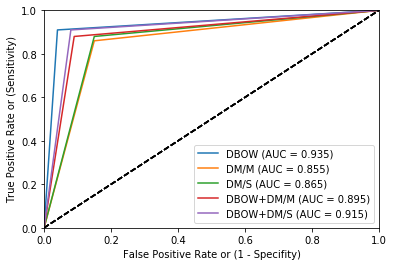

In [119]:
# errordocs = []
import matplotlib.pyplot as plt
from sklearn import metrics
model_name=['DBOW','DM/M','DM/S','DBOW+DM/M','DBOW+DM/S']
i=0
for line in allpreds:
#     print(list(map(int,line.predictions)))
    fpr, tpr, thresholds = metrics.roc_curve(list(map(int,line.sentiment)), list(map(int,line.predictions)))
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, label='%s (AUC = %0.3f)' % (model_name[i],roc_auc))
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
#     plt.title('Receiver Operating Characteristic for the five systems and their AUC(Area Under the ROC Curve) values')
    plt.legend(loc="lower right")
    i+=1
#     print(fpr,tpr)
    print(classification_report(line.sentiment, line.predictions))
#     for i in range(len(line.sentiment)):
        
#         if line.predictions[i]!=line.sentiment[i]:
#             errordocs.append(i)
# print(errordocs)

In [97]:
error_docs=[[26, 52, 64, 86, 107, 113, 120, 128, 134, 138, 180, 183, 184], [19, 22, 26, 27, 34, 35, 46, 52, 55, 62, 71, 74, 86, 89, 95, 107, 120, 132, 134, 138, 153, 162, 169, 182, 183, 184, 191, 193, 195], [18, 19, 22, 24, 25, 27, 34, 46, 52, 55, 58, 62, 74, 86, 89, 107, 117, 120, 134, 138, 153, 169, 182, 183, 184, 191, 193], [25, 26, 52, 55, 62, 71, 74, 76, 86, 107, 113, 120, 130, 134, 138, 149, 180, 182, 183, 184, 193], [19, 26, 34, 52, 62, 74, 83, 86, 107, 113, 120, 134, 138, 149, 180, 182, 183]]

In [98]:
for line in error_docs:
    print(line)

[26, 52, 64, 86, 107, 113, 120, 128, 134, 138, 180, 183, 184]
[19, 22, 26, 27, 34, 35, 46, 52, 55, 62, 71, 74, 86, 89, 95, 107, 120, 132, 134, 138, 153, 162, 169, 182, 183, 184, 191, 193, 195]
[18, 19, 22, 24, 25, 27, 34, 46, 52, 55, 58, 62, 74, 86, 89, 107, 117, 120, 134, 138, 153, 169, 182, 183, 184, 191, 193]
[25, 26, 52, 55, 62, 71, 74, 76, 86, 107, 113, 120, 130, 134, 138, 149, 180, 182, 183, 184, 193]
[19, 26, 34, 52, 62, 74, 83, 86, 107, 113, 120, 134, 138, 149, 180, 182, 183]


In [93]:
collections.Counter(errordocs).most_common(20)

[(52, 5),
 (86, 5),
 (107, 5),
 (120, 5),
 (134, 5),
 (138, 5),
 (183, 5),
 (26, 4),
 (184, 4),
 (62, 4),
 (74, 4),
 (182, 4),
 (113, 3),
 (180, 3),
 (19, 3),
 (34, 3),
 (55, 3),
 (193, 3),
 (22, 2),
 (27, 2)]

In [99]:
' '.join(cv_test_docs[183].words)

'The summer of raunch continues to spread into theatres with this latest yuk fest, filled with sick jokes and teen dialogue aplenty. If you go expecting Dawson\'s Creek, you\'re in for a problem. If your expectations are lower (and better, I might add), you will enjoy the hell out of American Pie. The movie casts several unknowns, with the only real recognizable one being SCTV\'s own Eugene Levy as a happy-go-lucky dad. The story revolves around four high school seniors who have one goal before the school year gets out-get laid. That\'s pretty much it. Throughout the movie, little sick comic bits are sprinkled throughout, including a memorable scene involving an apple pie (I won\'t give it away, but you probably know what it is) and an Internet broadcast gone horribly awry. Of course, the movie has some slightly sentimental bits, but they don\'t drag the movie\'s humor content down that bad. Most of the actors get their job done, but it\'s Levy who\'s a hoot, a father who tries to talk

In [96]:
cv_test_docs[86].tags

[860]

Achieved Sentiment-Prediction Accuracy
--------------------------------------
Compare error rates achieved, best-to-worst



In [85]:
print("Err_rate Model")
for rate, name in sorted((rate, name) for name, rate in error_rates.items()):
    print("%f %s" % (rate, name))

Err_rate Model
0.065000 Doc2Vec(dbow,d100,n5,mc2,t8)
0.085000 Doc2Vec(dbow,d100,n5,mc2,t8)+Doc2Vec("sum",dm/s,d100,n5,w2,mc2,t8)
0.090000 Doc2Vec(dbow,d100,n5,mc2,t8)+Doc2Vec(dm/c,d100,n5,w5,mc2,t8)
0.095000 Doc2Vec(dbow,d100,n5,mc2,t8)+Doc2Vec("alpha=0.05",dm/m,d100,n5,w10,mc2,t8)
0.105000 Doc2Vec(dbow,d100,n5,mc2,t8)+Doc2Vec("mean",dm/m,d100,n5,w2,mc2,t8)
0.110000 Doc2Vec(dbow,d100,n5,mc2,t8)+Doc2Vec("w2",dm/m,d100,n5,w2,mc2,t8)
0.120000 Doc2Vec(dbow,d100,n5,mc2,t8)+Doc2Vec("mc5w5",dm/m,d100,n5,w5,mc5,t8)
0.130000 Doc2Vec("w2",dm/m,d100,n5,w2,mc2,t8)
0.135000 Doc2Vec("sum",dm/s,d100,n5,w2,mc2,t8)
0.140000 Doc2Vec("alpha=0.05",dm/m,d100,n5,w2,mc2,t8)
0.145000 Doc2Vec("mean",dm/m,d100,n5,w2,mc2,t8)
0.160000 Doc2Vec("hs=0",dm/m,d100,n5,hs,w5,mc2,t8)
0.160000 Doc2Vec("mc5w2",dm/m,d100,n5,w2,mc2,t8)
0.165000 Doc2Vec("mc5w5",dm/m,d100,n5,w5,mc5,t8)
0.175000 Doc2Vec("alpha=0.05",dm/m,d100,n5,w10,mc2,t8)
0.200000 Doc2Vec("alpha=0.025",dm/m,d100,n5,w10,mc2,t8)
0.250000 Doc2Vec(dm/c,d100,n5,w5

Are inferred vectors close to the precalculated ones?
-----------------------------------------------------



In [28]:
doc_id = np.random.randint(simple_models[0].docvecs.count)  # Pick random doc; re-run cell for more examples
print('for doc %d...' % doc_id)
for model in simple_models:
    inferred_docvec = model.infer_vector(alldocs[doc_id].words)
    print('%s:\n %s' % (model, model.docvecs.most_similar([inferred_docvec], topn=3)))
    print(model.docvecs.most_similar([inferred_docvec], topn=1)[0][0])

for doc 28066...
Doc2Vec(dbow,d100,n5,mc2,t8):
 [(28066, 0.9800949096679688), (32916, 0.633941650390625), (81052, 0.6129944324493408)]
28066
Doc2Vec("mean",dm/m,d100,n5,w2,mc2,t8):
 [(28066, 0.9476486444473267), (5994, 0.6039725542068481), (8328, 0.5808252096176147)]
28066
Doc2Vec("sum",dm/s,d100,n5,w2,mc2,t8):
 [(28066, 0.9541605710983276), (8328, 0.7591161131858826), (12457, 0.7508106231689453)]
28066


In [35]:
ms = np.zeros(shape=(3,100))
mslist = np.zeros(shape=(3,100,3,2))
for i in range(100):
    doc_id = np.random.randint(simple_models[0].docvecs.count)  # Pick random doc; re-run cell for more examples
# print('for doc %d...' % doc_id)
    j=0
    for model in simple_models:
        inferred_docvec = model.infer_vector(alldocs[doc_id].words)
        mslist[j][i] = model.docvecs.most_similar([inferred_docvec], topn=3)
        if doc_id == model.docvecs.most_similar([inferred_docvec], topn=3)[0][0]:
            ms[j][i] = 1
        else:
            ms[j][i] = 0
        j+=1
#         print('%s:\n %s' % (model, model.docvecs.most_similar([inferred_docvec], topn=3)))

In [36]:
ms

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        0., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.

(Yes, here the stored vector from 20 epochs of training is usually one of the
closest to a freshly-inferred vector for the same words. Defaults for
inference may benefit from tuning for each dataset or model parameters.)




Do close documents seem more related than distant ones?
-------------------------------------------------------



In [32]:
import random

doc_id = np.random.randint(simple_models[0].docvecs.count)  # pick random doc, re-run cell for more examples
model = random.choice(simple_models)  # and a random model
sims = model.docvecs.most_similar(doc_id, topn=model.docvecs.count)  # get *all* similar documents
print(u'TARGET (%d): «%s»\n' % (doc_id, ' '.join(alldocs[doc_id].words)))
print(u'SIMILAR/DISSIMILAR DOCS PER MODEL %s:\n' % model)
for label, index in [('MOST', 0), ('MEDIAN', len(sims)//2), ('LEAST', len(sims) - 1)]:
    s = sims[index]
    i = sims[index][0]
    words = ' '.join(alldocs[i].words)
    print(u'%s %s: «%s»\n' % (label, s, words))

TARGET (74907): «spoofing horror films is something people think is easy. in truth, it isn't. just being stupid doesn't make something funny. it just makes it stupid. throwing a bunch of naked chicks in the flick only makes me think of some porn i'd rather be watching.<br /><br />this is a bad movie that isn't scary. it isn't funny. heck, it isn't even gory. it is boring. i guess that's something.»

SIMILAR/DISSIMILAR DOCS PER MODEL Doc2Vec("sum",dm/s,d100,n5,w2,mc2,t8):

MOST (11352, 0.7791767120361328): «Leslie Nielson is a very talented actor, who made a huge mistake by doing this film. It doesn't even come close to being funny. The best word to describe it is STUPID!»

MEDIAN (93819, 0.5388213992118835): «Namely, the cinematography is gorgeous, the acting either overblown or wooden, the dialog absurd, and the story - well, the writer should be patted on the head and sent back to school, with the script posted proudly on the refrigerator.<br /><br />What I liked: as I said, the came

Do the word vectors show useful similarities?
---------------------------------------------




In [38]:
import random

word_models = simple_models[:]

def pick_random_word(model, threshold=10):
    # pick a random word with a suitable number of occurences
    while True:
        word = random.choice(model.wv.index2word)
        if model.wv.vocab[word].count > threshold:
            return word

target_word = pick_random_word(word_models[0])
# or uncomment below line, to just pick a word from the relevant domain:
# target_word = 'comedy/drama'

for model in word_models:
    print('target_word: %r model: %s similar words:' % (target_word, model))
    for i, (word, sim) in enumerate(model.wv.most_similar(target_word, topn=10), 1):
        print('    %d. %.2f %r' % (i, sim, word))
    print()

2020-01-08 23:23:27,988 : INFO : precomputing L2-norms of word weight vectors


target_word: 'boundless' model: Doc2Vec(dbow,d100,n5,mc2,t8) similar words:


2020-01-08 23:23:28,249 : INFO : precomputing L2-norms of word weight vectors
2020-01-08 23:23:28,378 : INFO : precomputing L2-norms of word weight vectors


    1. 0.44 'wife!".'
    2. 0.42 'on-target.'
    3. 0.41 'Incoherent'
    4. 0.41 'HOLE!!)'
    5. 0.41 'hirsute'
    6. 0.40 'Cameroons'
    7. 0.40 'co-incidence'
    8. 0.40 'Zoo,'
    9. 0.39 'Operating'
    10. 0.39 'done".'

target_word: 'boundless' model: Doc2Vec("mean",dm/m,d100,n5,w2,mc2,t8) similar words:
    1. 0.56 'perseverance,'
    2. 0.55 'blasts,'
    3. 0.55 'Danny(Paul'
    4. 0.54 'tenderness,'
    5. 0.54 'medication.<br'
    6. 0.54 'inventiveness,'
    7. 0.54 'sadness,'
    8. 0.53 'vanity,'
    9. 0.53 'innate'
    10. 0.52 "Strudwick's"

target_word: 'boundless' model: Doc2Vec("sum",dm/s,d100,n5,w2,mc2,t8) similar words:
    1. 0.62 'medication.<br'
    2. 0.62 'uncontained'
    3. 0.61 'blasts,'
    4. 0.60 'tenderness,'
    5. 0.59 'perseverance,'
    6. 0.58 'unbridled'
    7. 0.58 'intuition,'
    8. 0.57 'expending'
    9. 0.57 'sadness,'
    10. 0.56 'anxiety,'



Are the word vectors from this dataset any good at analogies?
-------------------------------------------------------------



In [39]:
# grab the file if not already local
questions_filename = 'questions-words.txt'
if not os.path.isfile(questions_filename):
    # Download IMDB archive
    print("Downloading analogy questions file...")
    url = u'https://raw.githubusercontent.com/tmikolov/word2vec/master/questions-words.txt'
    with smart_open.open(url, 'rb') as fin:
        with smart_open.open(questions_filename, 'wb') as fout:
            fout.write(fin.read())
assert os.path.isfile(questions_filename), "questions-words.txt unavailable"
print("Success, questions-words.txt is available for next steps.")

# Note: this analysis takes many minutes
for model in word_models:
    score, sections = model.wv.evaluate_word_analogies('questions-words.txt')
    correct, incorrect = len(sections[-1]['correct']), len(sections[-1]['incorrect'])
    print('%s: %0.2f%% correct (%d of %d)' % (model, float(correct*100)/(correct+incorrect), correct, correct+incorrect))

Success, questions-words.txt is available for next steps.


2020-01-08 23:24:04,765 : INFO : Evaluating word analogies for top 300000 words in the model on questions-words.txt
2020-01-08 23:24:06,780 : INFO : capital-common-countries: 0.0% (0/420)
2020-01-08 23:24:11,109 : INFO : capital-world: 0.0% (0/902)
2020-01-08 23:24:11,526 : INFO : currency: 0.0% (0/86)
2020-01-08 23:24:18,709 : INFO : city-in-state: 0.0% (0/1510)
2020-01-08 23:24:21,104 : INFO : family: 0.0% (0/506)
2020-01-08 23:24:25,811 : INFO : gram1-adjective-to-adverb: 0.0% (0/992)
2020-01-08 23:24:29,436 : INFO : gram2-opposite: 0.0% (0/756)
2020-01-08 23:24:35,653 : INFO : gram3-comparative: 0.0% (0/1332)
2020-01-08 23:24:40,648 : INFO : gram4-superlative: 0.0% (0/1056)
2020-01-08 23:24:45,347 : INFO : gram5-present-participle: 0.0% (0/992)
2020-01-08 23:24:52,217 : INFO : gram6-nationality-adjective: 0.0% (0/1445)
2020-01-08 23:24:59,508 : INFO : gram7-past-tense: 0.0% (0/1560)
2020-01-08 23:25:05,103 : INFO : gram8-plural: 0.0% (0/1190)
2020-01-08 23:25:09,201 : INFO : gram9-

Doc2Vec(dbow,d100,n5,mc2,t8): 0.00% correct (0 of 13617)


2020-01-08 23:25:09,554 : INFO : Evaluating word analogies for top 300000 words in the model on questions-words.txt
2020-01-08 23:25:11,877 : INFO : capital-common-countries: 1.7% (7/420)
2020-01-08 23:25:17,371 : INFO : capital-world: 0.3% (3/902)
2020-01-08 23:25:17,931 : INFO : currency: 0.0% (0/86)
2020-01-08 23:25:25,958 : INFO : city-in-state: 0.1% (2/1510)
2020-01-08 23:25:28,970 : INFO : family: 37.5% (190/506)
2020-01-08 23:25:34,695 : INFO : gram1-adjective-to-adverb: 3.7% (37/992)
2020-01-08 23:25:39,000 : INFO : gram2-opposite: 6.7% (51/756)
2020-01-08 23:25:46,477 : INFO : gram3-comparative: 46.4% (618/1332)
2020-01-08 23:25:52,777 : INFO : gram4-superlative: 31.3% (331/1056)
2020-01-08 23:25:58,434 : INFO : gram5-present-participle: 23.1% (229/992)
2020-01-08 23:26:06,485 : INFO : gram6-nationality-adjective: 3.7% (53/1445)
2020-01-08 23:26:15,679 : INFO : gram7-past-tense: 23.8% (372/1560)
2020-01-08 23:26:22,767 : INFO : gram8-plural: 16.3% (194/1190)
2020-01-08 23:26:2

Doc2Vec("mean",dm/m,d100,n5,w2,mc2,t8): 17.87% correct (2433 of 13617)


2020-01-08 23:26:28,743 : INFO : Evaluating word analogies for top 300000 words in the model on questions-words.txt
2020-01-08 23:26:30,910 : INFO : capital-common-countries: 1.9% (8/420)
2020-01-08 23:26:35,618 : INFO : capital-world: 0.7% (6/902)
2020-01-08 23:26:36,098 : INFO : currency: 0.0% (0/86)
2020-01-08 23:26:44,068 : INFO : city-in-state: 0.3% (4/1510)
2020-01-08 23:26:46,971 : INFO : family: 36.8% (186/506)
2020-01-08 23:26:52,423 : INFO : gram1-adjective-to-adverb: 5.4% (54/992)
2020-01-08 23:26:56,793 : INFO : gram2-opposite: 5.4% (41/756)
2020-01-08 23:27:06,094 : INFO : gram3-comparative: 46.5% (620/1332)
2020-01-08 23:27:12,559 : INFO : gram4-superlative: 34.7% (366/1056)
2020-01-08 23:27:18,883 : INFO : gram5-present-participle: 26.6% (264/992)
2020-01-08 23:27:27,190 : INFO : gram6-nationality-adjective: 2.8% (41/1445)
2020-01-08 23:27:36,171 : INFO : gram7-past-tense: 19.4% (303/1560)
2020-01-08 23:27:43,199 : INFO : gram8-plural: 14.2% (169/1190)
2020-01-08 23:27:4

Doc2Vec("sum",dm/s,d100,n5,w2,mc2,t8): 17.93% correct (2441 of 13617)
